# World Happiness – Regional Interpretation of Well-Being
**Student:** Bakhtiyor Sohibnazarov  
**Student Number:** Z22590018  
**Module:** Data Visualization   
**Date Updated:** December 23, 2025

## 1. Importing Libraries
Section installs and imports required libraries used in this notebook    
It will also import and display first few rows of raw dataset for inspection


In [1]:
# Run this block to install required libraries if missing.
!pip install pandas numpy matplotlib seaborn

In [2]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load initial dataset
df = pd.read_csv("dataset/world-happiness-report.csv")
df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850,0.584,0.237
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707,0.618,0.275
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731,0.611,0.267
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776,0.710,0.268


## 2. Data Preparation
### Cleanup

This section performs light cleaning and ensures that key variables are available in a consistent format.   
Rename cols for easier analysis. We will note use Postive and Negative affect cols so its best to remove them from dataset we are analyzing

In [3]:
# Rename original colonumns with given new names
df = df.rename(columns={
    "Country name": "Country",
    "year": "Year",
    "Life Ladder": "Happiness",
    "Log GDP per capita": "GDP",
    "Social support": "SocialSupport",
    "Healthy life expectancy at birth": "Health",
    "Freedom to make life choices": "Freedom",
    "Perceptions of corruption": "Corruption"
})

# Drop cols
df = df.drop(columns=["Positive affect", "Negative affect"], errors="ignore")
df.head()

,Country,Year,Happiness,GDP,SocialSupport,Health,Freedom,Generosity,Corruption
0,Afghanistan,2008,3.724,7.370,0.451,50.80,0.718,0.168,0.882
1,Afghanistan,2009,4.402,7.540,0.552,51.20,0.679,0.190,0.850
2,Afghanistan,2010,4.758,7.647,0.539,51.60,0.600,0.121,0.707
3,Afghanistan,2011,3.832,7.620,0.521,51.92,0.496,0.162,0.731
4,Afghanistan,2012,3.783,7.705,0.521,52.24,0.531,0.236,0.776


### Year Continuity Check
As the dataset contains country-level observations across multiple years, an assessment of year continuity was conducted before further analysis. This step ensures that differences in temporal coverage do not introduce bias into the analytical pipeline.

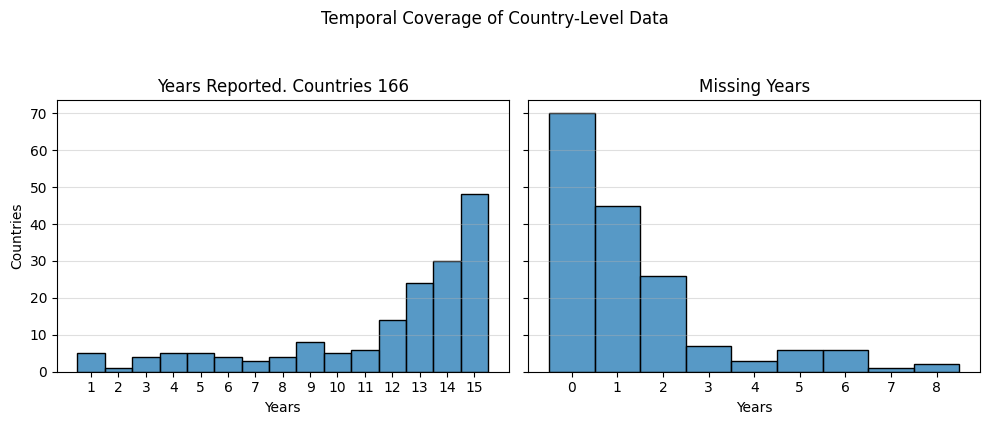

In [21]:
coverage = (
    df.groupby("Country")["Year"]
      .agg(YearsReported="nunique", YearMin="min", YearMax="max")
      .assign(
          MissingYears=lambda x: (x["YearMax"] - x["YearMin"] + 1) - x["YearsReported"]))

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Years Reported
sns.histplot(coverage["YearsReported"], discrete=True, ax=axes[0])

axes[0].set_title(f"Years Reported. Countries {len(coverage)}")
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Countries")
axes[0].set_xticks(range(coverage["YearsReported"].min(), coverage["YearsReported"].max() + 1))
axes[0].grid(True, axis="y", alpha=0.4)

# Missing Years
sns.histplot(coverage["MissingYears"], discrete=True, ax=axes[1])

axes[1].set_title("Missing Years")
axes[1].set_xlabel("Years")
axes[1].set_xticks(range(coverage["MissingYears"].min(), coverage["MissingYears"].max() + 1))
axes[1].grid(True, axis="y", alpha=0.4)

# Finalise
plt.suptitle("Temporal Coverage of Country-Level Data", y=1.05)
plt.tight_layout()
plt.savefig("country_year_coverage_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

### Consistency Filtering
Countries were evaluated based on the number of years reported. Only those with a minimum of three consecutive years were retained for analysis, ensuring sufficient temporal continuity and minimising bias introduced by inconsistent reporting.

In [5]:
MIN_YEARS = 3
years = np.sort(df["Year"].unique())

# Optimal contiguous window
windows = [(years[i], years[i + MIN_YEARS - 1])
           for i in range(len(years) - MIN_YEARS + 1)]

best_start, best_end = max(
    windows,
    key=lambda w: df[
        df["Year"].between(*w)
    ].groupby("Country")["Year"].nunique().ge(MIN_YEARS).sum()
)

# Lock window & enforce consistency
df_window = df[df["Year"].between(best_start, best_end)]
df_balanced = df_window.groupby("Country").filter(
    lambda x: x["Year"].nunique() >= MIN_YEARS
)

# Summary
print(f"Best window: {best_start}–{best_end}")

Best window: 2015–2017


## Interpolation
### Check missing data
We need to check if there is missing cells in the balanced dataset and interpolate where it is possible

In [6]:
# Check missing data by grouping
missing_by_country_var = (df_balanced.set_index(["Country", "Year"]).isna().groupby("Country").sum())

# Display
missing_by_country_var[missing_by_country_var.sum(axis=1) > 0]

,Happiness,GDP,SocialSupport,Health,Freedom,Generosity,Corruption
Country,,,,,,,
Bahrain,0,0,0,0,0,0,3
China,0,0,0,0,2,0,3
Egypt,0,0,0,0,0,0,1
Jordan,0,0,0,0,0,0,3
Kosovo,0,0,0,3,0,0,0
Kuwait,0,0,0,0,0,0,3
Libya,0,0,0,0,0,0,2
Palestinian Territories,0,0,0,3,0,0,0
Saudi Arabia,0,0,0,0,0,0,3


### Further Cleaning and Interpolation
Extreme missingness cannot be filled further, fabricated data will corrupt dataset. Remaining NaNs should be handled during analysis but extreme missingness should be removed in order to make dataset as much clean as possible. Therefore Corruption col and South Sudan can be removed to minimize missing data and stabilize GDP col respectively

In [9]:
# Remove country with structural GDP/Generosity gaps
df_balanced = df_balanced[df_balanced["Country"] != "South Sudan"].copy()

# Drop corruption due to systemic regional missingness
df_balanced = df_balanced.drop(columns=["Corruption"], errors="ignore")

num_cols = ["GDP", "SocialSupport", "Health", "Freedom", "Generosity"]

# Within-country interpolation (time-aware) WITHOUT groupby.apply (no FutureWarning)
df_balanced = df_balanced.sort_values(["Country", "Year"]).reset_index(drop=True)
df_balanced[num_cols] = (
    df_balanced.groupby("Country")[num_cols]
    .transform(lambda s: s.interpolate(method="linear", limit_direction="both"))
)

countries_original = set(df["Country"].unique())
countries_final = set(df_balanced["Country"].unique())

# Countries excluded by temporal consistency or cleaning
excluded_countries = countries_original - countries_final
df_excluded = df[df["Country"].isin(excluded_countries)].copy()

# Save Excluded countries
df_excluded.to_csv("excluded.csv", index=False)

# Save final file
df_balanced.to_csv("world_happiness_final.csv", index=False)

# Final summary
print("=== Final Dataset Summary ===")
print(f"Countries before preprocessing: {len(countries_original)}")
print(f"Countries after preprocessing:  {len(countries_final)}")
print(f"Excluded Countries {len(excluded_countries)} countries")
print(f"\nFinal dataset saved successfully...")

# Remaining missingness check (diagnostic only)
missing_by_country = df_balanced.isna().groupby(df_balanced["Country"]).sum()
missing_by_country[missing_by_country.sum(axis=1) > 0]

=== Final Dataset Summary ===
Countries before preprocessing: 166
Countries after preprocessing:  134
Excluded Countries 32 countries

Final dataset saved successfully...


,Country,Year,Happiness,GDP,SocialSupport,Health,Freedom,Generosity
Country,,,,,,,,
Kosovo,0,0,0,0,0,3,0,0
Palestinian Territories,0,0,0,0,0,3,0,0
Taiwan Province of China,0,0,0,0,0,3,0,0
